<a href="https://colab.research.google.com/github/FG2511/ARE/blob/master/project/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
@File name: model1.ipynb
@Created on 2018-12-20
@Authors: Federica Gerina, Francesca Moi, Silvia Maria Massa
@Description: Given a time-series dataset that contains minute-by-minute data 
about different kind of gases, collected by the uHoo air quality sensor, train
a NN that classifies if a minute belongs to the class "Pasto" (1) otherwise to
the class "Other" (0).
'''

!pip install liac-arff

import arff
import numpy as np

from keras import optimizers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization, Activation
from keras.callbacks import EarlyStopping

from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('local_modules')

import postprocessing_sliding
import postprocessing_Silvia
import plotting

Using TensorFlow backend.


In [0]:
#fix random seed for reproducibility
seed = 5
np.random.seed(seed)

In [0]:
'''
@Description: generate a multilayer perceptron with LeakyRelu as activation
function.
@param: 
  - shape : int, the shape of the input
  - n_features: int, the number of features given
'''

#MODELLO 1
#REGOLA: input/2, input, 2*input, 1
#layers TUTTE LE FEATURE: 57, 113, 226, 1 
#layers TIME CO2 TEMP: 21, 41, 82, 1 
#layers TIME CO2 TEMP PM25/TVOC: 30, 59, 118, 1 
#layers TIME CO2 TEMP PM25 TVOC: 39, 77, 154, 1 


def generate_model_leaky(shape, n_features):

  units_1 = int(n_features/2)
  units_2 = n_features
  units_3 = n_features*2

  model = Sequential()
  model.add(BatchNormalization())
  
  model.add(Dense(units_1, input_dim=shape, kernel_initializer='random_uniform',  use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  
  model.add(Dense(units_2, kernel_initializer='random_uniform',  use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  
  model.add(Dense(units_3, kernel_initializer='random_uniform',  use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  
  model.add(Dense(1, activation='sigmoid'))
  #print(model.summary())

  return model

In [0]:
'''
@Description: generate a multilayer perceptron with Relu as activation
function.
@param: 
  - shape : int, the shape of the input
  - n_features: int, the number of features given
'''

#MODELLO 2
#REGOLA: a= input, b= a*2/3+c, c= b*2/3+1
#layers TUTTE LE FEATURE: 113, 229, 153, 1
#layers TIME CO2 TEMP: 41, 85, 57, 1 
#layers TIME CO2 TEMP PM25/TVOC: 59, 121, 81, 1 
#layers TIME CO2 TEMP PM25 TVOC: 77, 157, 105, 1 

def generate_model(shape, n_features):
  
  a = np.array([[1,0,0],[-(2/3),1,-1],[0,-(2/3),1]])
  b = np.array([n_features,0,1])
  x = np.linalg.solve(a, b)

  units_1 = int(x[0])
  units_2 = int(x[1])
  units_3 = int(x[2])

  model = Sequential()
 
  model.add(Dense(units_1, input_dim=shape, kernel_initializer='random_uniform', use_bias = False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0,5))
  
  model.add(Dense(units_2, kernel_initializer='random_uniform', use_bias = False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0,5))
  
  model.add(Dense(units_3, kernel_initializer='random_uniform', use_bias = False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0,5))
  
  model.add(Dense(1, activation='sigmoid'))
  #print(model.summary())

  return model

In [5]:
#@title SCEGLI IL DATASET E IL MODELLO

'''
@Description: MAIN
'''

#LOAD DATA
print("Loading data...")

dataset = '/root/data/6_uHoo_featureDataset.arff' #@param {type:"string"}

with open (dataset, encoding='utf-8') as f:
  dataDictionary = arff.load(f)

data = np.array(dataDictionary['data'])
print("DATASET LOADED")

#CONVERTING VALUES
print("\nConverting values...")
for i in data:
  if(i[-1] == 'Other'): i[-1] = 0
  elif(i[-1] == 'Pasto') : i[-1] = 1

dataset = data.astype('float32')
print("CONVERSION DONE")

#SPLIT INTO INPUT (X) AND OUTPUT (Y) VARIABLES
s = dataset.shape[-1]
#print(s)
X = dataset[:,0:s-1]
Y = dataset[:,s-1]

#print(s-1)

n_features = s-1

#SPLIT INTO TRAINING, VALIDATION AND TEST SETS
print("\nSplit into training, validation and test sets...")

train_rate = 80
val_rate = 10
train = round(int((dataset.shape[0]*train_rate)/100))
val = round(int((dataset.shape[0]*(train_rate+val_rate))/100))

train_data = X[:train]
train_label = Y[:train]

val_data = X[train+1:val]
val_label = Y[train+1:val]

test_data = X[val+1:]
test_label = Y[val+1:]
print("DATASET SPLITTED")

#COMPUTE CLASS WEIGHT
labels = np.unique(train_label)
classWeight = compute_class_weight('balanced', labels, train_label)
classWeight = dict(zip(labels,classWeight))

#GENERATE MODEL
print("\nGenerate model...")

modello = 1 #@param {type:"integer"}

if modello==1 :
  model = generate_model_leaky(train_data.shape[-1], n_features)
elif modello==2:
  model = generate_model(train_data.shape[-1], n_features)

#OPTIMIZERS
adm = optimizers.Adam(lr=0.0001)

#COMPILE MODEL
print("\nCompile model...")
model.compile(loss='binary_crossentropy', optimizer = adm , metrics=['accuracy'])

#EARLY STOPPING
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

#FIT MODEL
print("\nFit model...")
history = model.fit(train_data, train_label, epochs=10, validation_data = (val_data, val_label), batch_size = 128, shuffle = True, class_weight = classWeight, verbose=1, callbacks = [es])

#EVALUATE MODEL
print("\nEvaluate model...")
scores_test = model.evaluate(test_data, test_label, batch_size=128, verbose = 1)
print("Test loss: %.2f%%" % (scores_test[0] * 100))
print("Test accuracy: %.2f%%" % (scores_test[1] * 100))

#CALCULATE PREDICTIONS
print("\nCalculate predictions...")
pred = model.predict_classes(test_data, batch_size=128, verbose=0)
flat_pred = [item for sublist in pred for item in sublist]

#CONFUSION MATRIX
print("\nCompute confusion matrix...")
y_true = test_label
y_pred = pred
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("TN", tn)
print("FP", fp)
print("FN", fn)
print("TP", tp)
other = 100*tn/(tn+fp)
pasto = 100*tp/(fn+tp)
print("Other corretti: %.2f %%" % other)
print("Pasto corretti: %.2f %%" % pasto)

Loading data...
DATASET LOADED

Converting values...
CONVERSION DONE

Split into training, validation and test sets...
DATASET SPLITTED

Generate model...
Instructions for updating:
Colocations handled automatically by placer.

Compile model...

Fit model...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 183944 samples, validate on 22992 samples
Epoch 1/10
183944/183944 [==============================] - 13s 73us/step - loss: 0.5357 - acc: 0.7327 - val_loss: 0.3529 - val_acc: 0.8901
Epoch 2/10
183944/183944 [==============================] - 11s 60us/step - loss: 0.4117 - acc: 0.8373 - val_loss: 0.2787 - val_acc: 0.8868
Epoch 3/10
183944/183944 [==============================] - 11s 59us/step - loss: 0.3731 - acc: 0.8421 - val_loss: 0.2619 - val_acc: 0.8809
Epoch 4/10
183944/183944 [==============================] - 11s 60us/step - loss: 0.3579 - acc: 0.8431 - va

In [6]:
#@title SCEGLI maxWidth
'''
@Description: POST PROCESSING
'''

maxWidth = 3 #@param {type:"integer"}

new_pred = postprocessing_sliding.sliding_windows(flat_pred)
#new_pred = postprocessing_Silvia.setWidth(maxWidth,flat_pred)

#CONFUSION MATRIX
print("\nCompute NEW confusion matrix...")
y_true = test_label
n_y_pred = new_pred
tn, fp, fn, tp = confusion_matrix(y_true, n_y_pred).ravel()
print("TN", tn)
print("FP", fp)
print("FN", fn)
print("TP", tp)
other = 100*tn/(tn+fp)
pasto = 100*tp/(fn+tp)
print("Other corretti: %.2f %%" % other)
print("Pasto corretti: %.2f %%" % pasto)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

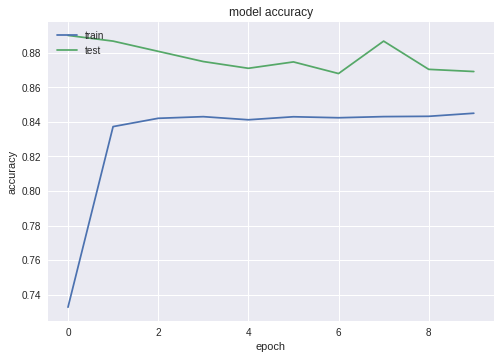

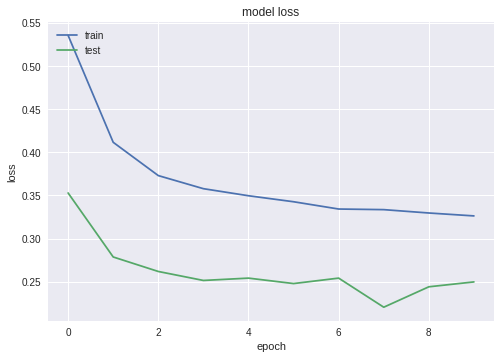

In [7]:
'''
@Description: PLOTTING
'''

plotting.plot_model_results(history)
plotting.plot_co2_temp(flat_pred, val)

In [0]:
#model.save('my_model1.h5')
#model = load_model('my_model.h5')